# Imports 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
from torch import nn, optim 
from torch.utils.data import Dataset, DataLoader 

from torchvision import transforms as T

import timm

![](Untitled-design.png)

# Configurations

In [2]:
TRAIN_PATH = 'train.csv'
VALID_PATH = 'valid.csv'
BATCH_SIZE = 128
MODEL_NAME = 'efficientnet_b0'

In [3]:
df_train = pd.read_csv('train.csv')
df_valid = pd.read_csv('valid.csv')

In [4]:
# df_train

In [5]:
print(f"No. of examples present in df_train : {len(df_train)}")
print(f"No. of examples present in df_valid : {len(df_valid)}")
print(f"Labels are : {df_train['labels'].unique()}")

No. of examples present in df_train : 3200
No. of examples present in df_valid : 800
Labels are : ['Squiggle' 'Narrowbanddrd' 'Noises' 'Narrowband']


# Declare Spec Augmentations 

We can't apply random rotation or vertical flip -> changes the state of radio signal

![](image6.png)

In [68]:
def get_train_transform():
    return T.compose(
    [
        TimeMask(T=15, num_masks=4), # width of Mask, number of masks
        FreqMask(F=15, num_masks=3)
    ])

In [6]:
from spec_augment import TimeMask, FreqMask

 Frequency masking is applied so that f consecutive mel frequency channels [f0, f0 + f) are masked, where f is first chosen from a uniform distribution from 0 to the frequency mask parameter F, and f0 is chosen from 0, ν − f). ν is the number of mel frequency channels.

# Create Custom Dataset 

In [49]:
class CustomImageDataset(Dataset):
    def __init__(self, df, augmentation=False):

        self.augmentation = augmentation
        self.df = df
        label_hashmap = {
            'Squiggle' : 0, 
            'Narrowband' : 1, 
            'Narrowbanddrd' : 2,
            'Noises' : 3
        }
        self.df.loc[:, 'labels_enc'] = self.df.labels.map(label_hashmap)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        row = df_train.iloc[idx]
        image_flatten = np.array(row[:-2], dtype = np.float64)
        image = np.resize(image_flatten, (64, 128, 1))
        
        label = np.array(row.labels_enc, dtype = np.int64)
        
        image = torch.Tensor(image).permute(2, 0, 1) # ch, h, w
        

        if self.augmentation:
            self.augmentation(image)
            
        return image, label


In [50]:
trainset = CustomImageDataset(df_train)
validset = CustomImageDataset(df_valid)

0


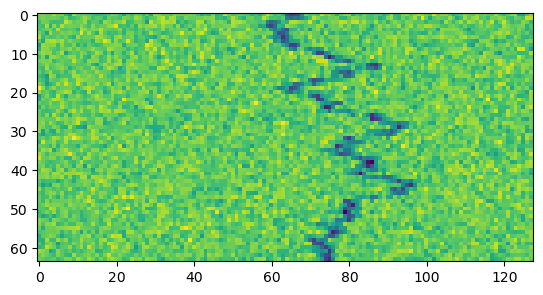

In [51]:
image, label = trainset[591]

plt.imshow(image.permute(0, 1, 2).squeeze())
print(label)

# Load dataset into Batches

In [52]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, \
                         shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [53]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 25
Total no. of batches in validloader : 7


In [54]:
for images, labels in trainloader:
    break
print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([128, 1, 64, 128])
One label batch shape : torch.Size([128])


# Load Model

In [13]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [62]:
class SpecModel(nn.Module):
    def __init__(self):
        super(SpecModel, self).__init__()
        
        self.net = timm.create_model('efficientnet_b0', \
                num_classes=4, pretrained=False, in_chans = 1)
        

        safetensors_path = 'model.safetensors'
        state_dict = load_file(safetensors_path)
        
        model_dict = self.net.state_dict()
        pretrained_dict = {k: v for k, v in state_dict.items() if k in model_dict and 'classifier' not in k}
        
        if 'conv_stem.weight' in pretrained_dict:
            pretrained_conv_stem_weight = pretrained_dict['conv_stem.weight']
            if pretrained_conv_stem_weight.shape[1] == 3:  # If the pretrained model has 3 input channels
                # Average the weights across the color channels to convert to single channel
                pretrained_conv_stem_weight = pretrained_conv_stem_weight.mean(dim=1, keepdim=True)
                pretrained_dict['conv_stem.weight'] = pretrained_conv_stem_weight
        
        model_dict.update(pretrained_dict)
        self.net.load_state_dict(model_dict)
        
        # Modify the classifier layer to match the number of classes (4)
        num_features = self.net.get_classifier().in_features
        self.net.classifier = nn.Linear(num_features, 4)
        
    def forward(self, images, labels = None):
        logits = self.net(images)
        if labels is not None:
            loss = nn.CrossEntropyLoss() # multiclass classification
            return logits, loss(logits, labels)
        return logits
        

In [63]:
from safetensors.torch import load_file

In [64]:
model = SpecModel()
model

SpecModel(
  (net): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), 

# Create Train and Eval Function

In [17]:
from tqdm.notebook import tqdm 
from utils import multiclass_accuracy

In [18]:
DEVICE = 'cpu'

In [57]:
def train(model, dataloader, optimizer, current_epoch):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    progress_bar = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]"+ \
                       str(current_epoch+1) + '/' + str(EPOCHS))
    for t, data in enumerate(progress_bar):
        images, labels =  data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        logits, loss = model(images, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        
        temp = {'loss': '%6f' %float(total_loss /(t+1)), \
                'acc': '%6f' %float(total_acc / (t+1)) }
        
        progress_bar.set_postfix(temp)

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [58]:
def eval(model, dataloader, current_epoch):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    progress_bar = tqdm(dataloader, desc = "EPOCH" + "[VALID]"+ \
                       str(current_epoch+1) + '/' + str(EPOCHS))
    with torch.no_grad():
        for t, data in enumerate(progress_bar):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            logits, loss = model(images, labels)

            total_loss += loss.item()
            total_acc += multiclass_accuracy(logits, labels)

            temp = {'loss': '%6f' %float(total_loss /(t+1)), \
                    'acc': '%6f' %float(total_acc / (t+1)) }

            progress_bar.set_postfix(temp)

    return total_loss / len(dataloader), total_acc / len(dataloader)

# Training Loop 

In [59]:
EPOCHS = 5
LR = 0.01

In [60]:
def fit(model, trainloader, validloader, optimizer):
    best_valid_loss = np.Inf
    for i in range(EPOCHS):
        train_loss, train_acc = train(model, trainloader, optimizer, i)
        valid_loss, valid_acc = eval(model, validloader, i)
        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), \
                       MODEL_NAME + '-best-weights.pt')
            print("Saved best weights")
            best_valid_loss = valid_loss
            

In [65]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
fit(model, trainloader, validloader, optimizer)

EPOCH[TRAIN]1/5:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH[VALID]1/5:   0%|          | 0/7 [00:00<?, ?it/s]

Saved best weights


EPOCH[TRAIN]2/5:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH[VALID]2/5:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH[TRAIN]3/5:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH[VALID]3/5:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH[TRAIN]4/5:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH[VALID]4/5:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH[TRAIN]5/5:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH[VALID]5/5:   0%|          | 0/7 [00:00<?, ?it/s]

# Inference 

In [66]:
from utils import view_classify